In [ ]:
import pandas as pd
import json
import numpy as np
import matplotlib.pyplot as plt


In [19]:
with open('data/deadpool.json', 'r') as file:
    pose_data = json.load(file)

In [20]:
# Find weights

first_frame = pose_data[0]["frame"]

def find_normalized_relative_vec(from_landmark, to_landmark, frame):
    frame_obj = pose_data[frame - first_frame]
    fromx = frame_obj["landmarks"][from_landmark][0]
    fromy = frame_obj["landmarks"][from_landmark][1]
    fromz = frame_obj["landmarks"][from_landmark][2]
    tox = frame_obj["landmarks"][to_landmark][0]
    toy = frame_obj["landmarks"][to_landmark][1]
    toz = frame_obj["landmarks"][to_landmark][2]
    relative_vec = [tox - fromx, toy-fromy, toz-fromz]
    relative_vec_norm = np.sqrt((relative_vec[0])**2 + (relative_vec[1])**2 + (relative_vec[2])**2)
    return [relative_vec[0] / relative_vec_norm, relative_vec[1] / relative_vec_norm,relative_vec[2] / relative_vec_norm]

# format is from: to
# some keys are repeated so i should probably fix that
REL_VEC_MAP = {
    "LEFT_WRIST": "LEFT_ELBOW",
    "LEFT_ELBOW": "LEFT_SHOULDER",
    "LEFT_SHOULDER": "RIGHT_SHOULDER",
    "RIGHT_WRIST": "RIGHT_ELBOW",
    "RIGHT_ELBOW": "RIGHT_SHOULDER",
    "LEFT_SHOULDER": "LEFT_HIP",
    "RIGHT_SHOULDER": "RIGHT_HIP",
    "LEFT_HIP": "RIGHT_HIP",
    "LEFT_HIP": "LEFT_KNEE",
    "LEFT_KNEE": "LEFT_ANKLE",
    "RIGHT_HIP": "RIGHT_KNEE",
    "RIGHT_KNEE": "RIGHT_ANKLE"
}

REL_VEC_TUPS = (
    ("LEFT_WRIST", "LEFT_ELBOW"),
    ("LEFT_ELBOW", "LEFT_SHOULDER"),
    ("LEFT_SHOULDER", "RIGHT_SHOULDER"),
    ("RIGHT_WRIST", "RIGHT_ELBOW"),
    ("RIGHT_ELBOW", "RIGHT_SHOULDER"),
    ("LEFT_SHOULDER", "LEFT_HIP"),
    ("RIGHT_SHOULDER", "RIGHT_HIP"),
    ("LEFT_HIP", "RIGHT_HIP"),
    ("LEFT_HIP", "LEFT_KNEE"),
    ("LEFT_KNEE", "LEFT_ANKLE"),
    ("RIGHT_HIP", "RIGHT_KNEE"),
    ("RIGHT_KNEE", "RIGHT_ANKLE")
)

all_parts = ['LEFT_ANKLE', 'LEFT_ELBOW', 'LEFT_HIP', 'LEFT_KNEE', 'LEFT_SHOULDER', 'LEFT_WRIST', 'RIGHT_ANKLE', 'RIGHT_ELBOW', 'RIGHT_HIP', 'RIGHT_KNEE', 'RIGHT_SHOULDER', 'RIGHT_WRIST']




In [21]:
def find_normalized_relative_vec_from_obj(from_landmark, to_landmark, frame_obj):
    fromx = frame_obj["landmarks"][from_landmark][0]
    fromy = frame_obj["landmarks"][from_landmark][1]
    fromz = frame_obj["landmarks"][from_landmark][2]
    tox = frame_obj["landmarks"][to_landmark][0]
    toy = frame_obj["landmarks"][to_landmark][1]
    toz = frame_obj["landmarks"][to_landmark][2]
    relative_vec = [tox - fromx, toy-fromy, toz-fromz]
    relative_vec_norm = np.sqrt((relative_vec[0])**2 + (relative_vec[1])**2 + (relative_vec[2])**2)
    return [relative_vec[0] / relative_vec_norm, relative_vec[1] / relative_vec_norm,relative_vec[2] / relative_vec_norm]

def find_sim(template_frame, user_frame, weights):
    sims = [] #form at is (from_joint, to_joint, difference)
    pure_sims_array = []
    for rel_vec in REL_VEC_TUPS:
        user_vec = find_normalized_relative_vec_from_obj(rel_vec[0], rel_vec[1], template_frame)
        temp_vec = find_normalized_relative_vec_from_obj(rel_vec[0], rel_vec[1], user_frame)
        diff_dot = np.dot(np.array(user_vec), np.array(temp_vec))
        sims.append((rel_vec[0], rel_vec[1], diff_dot))
        pure_sims_array.append(diff_dot)
    
    dot_product = np.dot(pure_sims_array, weights)
    return dot_product, sims

def find_weights(pose_data_subset):
    weights = []
    for rel_vec in REL_VEC_TUPS:
        diffs = []

        from_joint = rel_vec[0]
        to_joint = rel_vec[1]

        for i in range(1, len(pose_data_subset)):
            first_normed_rel_vec = find_normalized_relative_vec(from_joint, to_joint, i-1)
            second_normed_rel_vec = find_normalized_relative_vec(from_joint, to_joint, i)
            diff_norm = np.linalg.norm(np.array(second_normed_rel_vec) - np.array(first_normed_rel_vec))
            diffs.append(diff_norm)

        weights.append(sum(diffs))
    return weights


weights = find_weights(pose_data)
    

In [22]:
"""
[{'frame': 0,
  'timestamp': 0.0,
  'landmarks': {'LEFT_SHOULDER': [0.19183723628520966,
    0.4527665972709656,
    0.11228542774915695],
   'RIGHT_SHOULDER': [-0.11523714661598206,
    0.5224035382270813,
    0.0618785098195076],
   'LEFT_ELBOW': [0.28123152256011963,
    0.28129351139068604,
    0.13979975879192352],
   'RIGHT_ELBOW': [-0.19556871056556702,
    0.2384415864944458,
"""

# expected and actual are in the 'landmarks' dictionary format above

"""
def calculate_vectors(expected, actual):

    expected_vectors = {}
    actual_vectors = {}

    for key in REL_VEC_TUPS:
        expected_vector = (np.array(expected[key[0]]) - np.array(expected[key[1]]))
        expected_vectors[key] = expected_vector
        actual_vector = (np.array(actual[key[0]]) - np.array(actual[key[1]]))
        actual_vectors[key] = actual_vector

    return (expected_vectors, actual_vectors)
"""

#calculate_vectors(pose_data[0]['landmarks'], pose_data[100]['landmarks'])
    


'\ndef calculate_vectors(expected, actual):\n\n    expected_vectors = {}\n    actual_vectors = {}\n\n    for key in REL_VEC_TUPS:\n        expected_vector = (np.array(expected[key[0]]) - np.array(expected[key[1]]))\n        expected_vectors[key] = expected_vector\n        actual_vector = (np.array(actual[key[0]]) - np.array(actual[key[1]]))\n        actual_vectors[key] = actual_vector\n\n    return (expected_vectors, actual_vectors)\n'

In [23]:
def calculate_vectors(expected, actual):

    exp_and_actual_vec = {}

    for key in REL_VEC_TUPS:
        expected_vector = (np.array(expected[key[0]]) - np.array(expected[key[1]]))
        actual_vector = (np.array(actual[key[0]]) - np.array(actual[key[1]]))
        exp_and_actual_vec[key] = [(expected_vector, actual_vector)]

    return exp_and_actual_vec

#calculate_vectors(pose_data[0]['landmarks'], pose_data[100]['landmarks'])

In [24]:
# expected_frames: list of dictionaries of lists

def calculate_norm(expected_frames, actual_frames, weights):

    total = np.array([])

    for i in range(len(expected_frames)):
        vectors = calculate_vectors(expected_frames[i], actual_frames[i])

        list_of_diffs = np.array([])

        for num, key in enumerate(REL_VEC_TUPS):
            vector1 = vectors[key][0][0]
            vector2 = vectors[key][0][1]
            cosine_similarity = np.dot(vector1, vector2) / (np.linalg.norm(vector1) * np.linalg.norm(vector2))
            list_of_diffs = np.append(list_of_diffs, (cosine_similarity + 1)/2 * weights[num])

        avg = list_of_diffs.sum() / len(list_of_diffs)
        total = np.append(total, avg)

    return sum(total) / len(total)

In [25]:
test = [{'landmarks': {x: list(np.random.uniform(-1, 1, size=(1, 3))) for x in all_parts}} for i in range(200)]

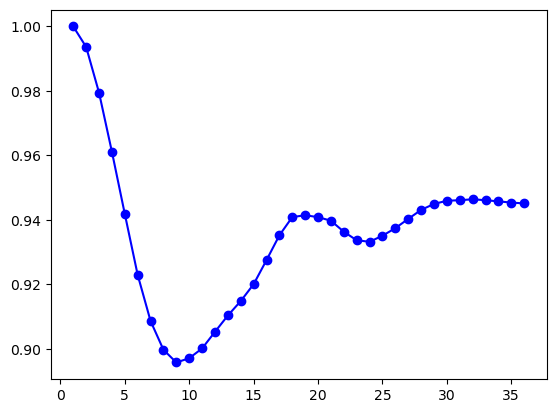

In [32]:
"""export type PoseType = {
  frame: number;
  timestamp: number;
  landmarks: Record<string, number[]>;
};"""

# Expected Movements: PoseTypeObject List of length fpb
# Actual Movements: PoseTypeObject List of length fbp * 4
# Output: dictionary with list of lists of lists

def softmax(x):
    e_x = np.exp(x - np.max(x))  # Shift values for numerical stability
    return e_x / e_x.sum(axis=0, keepdims=True)

def calculate_grade_for_groups(expected_movements, actual_movements):
    
    weights = [softmax(x) for x in find_weights(expected_movements)]
    grade_per_timestamp_group = {}
    needed_expected_movements = [data['landmarks'] for data in expected_movements]

    for i in range(len(expected_movements), len(actual_movements)):
        rang = (i-len(expected_movements), i)
        needed_actual_movements = [data['landmarks'] for data in actual_movements[rang[0]:rang[1]]]
        grade = calculate_norm(needed_expected_movements, needed_actual_movements, weights)
        grade_per_timestamp_group[rang] = grade

    return grade_per_timestamp_group

data = calculate_grade_for_groups(pose_data[0:12], pose_data[0:48]).values()
x = np.arange(1, len(data) + 1)

plt.plot(x, data, marker='o', linestyle='-', color='b', label='Data')


In [36]:
def calculate_highest_grade(expected_movements, actual_movements):
    return max(list(calculate_grade_for_groups(expected_movements, actual_movements).values()))

#calculate_highest_grade(pose_data[0:12], pose_data[0:48])

In [ ]:
def calculate_highest_vectors(expected_movements, actual_movements):

    best_range_with_val = max(calculate_grade_for_groups(expected_movements, actual_movements).items(),key = lambda x: x[1])
    best_range = best_range_with_val[0]
    desired_actual = actual_movements[best_range[0]:best_range[1]]
    curr_dict = calculate_vectors(expected_movements[0]['landmarks'], desired_actual[0]['landmarks'])
    for i in range(1,len(expected_movements)):
        dct = calculate_vectors(expected_movements[i]['landmarks'], desired_actual[i]['landmarks'])
        for key, value in dct.items():
            curr_dict[key].append(value[0])
    return curr_dict

output = calculate_highest_vectors(pose_data[0:12], pose_data[12:60])


In [54]:
# Convert numpy arrays to regular lists
for key, value in output.items():
    for i, (arr1, arr2) in enumerate(value):
        output[key][i] = (list(arr1), list(arr2))

#output
